In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from torch import nn
from torch.distributions import Normal
import abc

In [26]:
class ActionSelector(nn.Module, abc.ABC):
    def __init__(self, k):
        """
        :param k: Number of candidates that will be created
        """
        super().__init__()
        self.k = k

    @abc.abstractmethod
    def forward(self, **kwargs) -> tuple[torch.Tensor, torch.Tensor]:
        """
        returns
            - actions: Shape [k x N]
                0 = NOOP
                1 = Clone
                2 = Split
                3 = Prune (does not work in old implementation)
            - log_probabilities for each candidate: Shape [k]
        """
        pass


class ParamNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=16, output_size=3, increase_bias=2.0, decrease_bias=-2.0):
        super(ParamNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.init_weights(increase_bias, decrease_bias)

    def init_weights(self, increase_bias=2.0, decrease_bias=-2.0):
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc3.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        #nn.init.zeros_(self.fc3.bias)
        
        # Initialize fc3 weights and biases for changed probabilities
        nn.init.zeros_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)  # Initialize biases to 0
        
        # Example: Increase the bias for a specific action to increase its initial probability
        # Assuming you want to favor the first action initially:
        self.fc3.bias.data[0] = increase_bias  # Increase bias for the first action
        self.fc3.bias.data[1] = decrease_bias  # Decrease bias for the second action
        self.fc3.bias.data[2] = decrease_bias  # Decrease bias for the third action
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ParamBasedActionSelector(ActionSelector):
    def __init__(self, input_size=3, k=2, hidden_size=16, output_size=3, increase_bias=2.0, decrease_bias=-2.0):
        super().__init__(k=k)
        self.param_network = ParamNetwork(input_size, hidden_size, output_size=output_size, increase_bias=increase_bias, decrease_bias=decrease_bias)

    def forward(self, inputs):
        # Get action probabilities from the parameter network
        logits = self.param_network(inputs)
        action_probs = torch.softmax(logits, dim=-1)
        # Print logits and action probabilities for debugging
        #print("Logits: ", logits)
        #print("Action probabilities: ", action_probs)
        
        # Probabilistically sample k action candidates using rsample
        action_dist = torch.distributions.Categorical(action_probs)
        actions = action_dist.sample((self.k,)).to("cpu")   # using sample for discrete actions
        log_probs = action_dist.log_prob(actions)

        return actions, log_probs.squeeze(), action_probs
    
    def get_policy(self, inputs):
        # Get logits from the parameter network
        logits = self.param_network(inputs)
        # Compute action probabilities
        action_probs = torch.softmax(logits, dim=-1)
        # Create a categorical distribution over actions
        action_dist = torch.distributions.Categorical(probs=action_probs)
        return action_dist

In [27]:
torch.manual_seed(42)

In [28]:
import ast

def get_stats():
    # Path to the text file
    file_path = '/bigwork/nhmlhuer/gaussian-splatting/grad_and_scaling_and_opacity_2.txt'

    # Lists to store the parsed values
    grad_stats = []
    scaling_stats = []
    opacity_stats = []

    # Read the file and parse each entry
    with open(file_path, 'r') as f:
        for line in f:
            # Parse the line as a dictionary
            entry = ast.literal_eval(line.strip())
            
            # Extract grad, scaling, and opacity stats
            grad_stats.append({'mean': entry['mean_grad_value'], 'std': entry['std_grad_value']})
            scaling_stats.append({'mean': entry['mean_scaling'], 'std': entry['std_scaling']})
            opacity_stats.append({'mean': entry['mean_opacity'], 'std': entry['std_opacity']})  # Default opacity if not present

    return grad_stats, scaling_stats, opacity_stats

def generate_sample_data(num_samples, grad_stats, scaling_stats, opacity_stats, device='cuda'):
    all_grads = []
    all_scalings = []
    all_opacities = []
    
    # Sample for each range (start, mid, late)
    for grad_stat, scaling_stat, opacity_stat in zip(grad_stats, scaling_stats, opacity_stats):
        # Number of samples per range
        num_samples_per_range = num_samples // len(grad_stats)
        grads = torch.normal(mean=grad_stat['mean'], std=grad_stat['std'], size=(num_samples_per_range,), device=device)
        scaling = torch.normal(mean=scaling_stat['mean'], std=scaling_stat['std'], size=(num_samples_per_range,), device=device)
        opacities = torch.normal(mean=opacity_stat['mean'], std=opacity_stat['std'], size=(num_samples_per_range,), device=device)

        all_grads.append(grads)
        all_scalings.append(scaling)
        all_opacities.append(opacities)

    # Concatenate all samples from different phases
    all_grads = torch.cat(all_grads, dim=0)
    all_scalings = torch.cat(all_scalings, dim=0)
    all_opacities = torch.cat(all_opacities, dim=0)

    return all_grads, all_scalings, all_opacities

In [29]:
normalized = False
pruning = False
output_size = 4 if pruning else 3
# Load the saved model
action_selector = ParamBasedActionSelector(k=1, hidden_size=16, output_size=output_size, increase_bias=-2.0, decrease_bias=2.0).to("cpu")

#model_path = "../gaussian_splatting_rl/hydra/multirun/2024-09-05/22-42-59/4/meta_model.torch"
#model_path = "/bigwork/nhmlhuer/git/gaussian_splatting_rl/hydra/multirun/2024-09-11/21-37-47/7/meta_model.torch"
#model_path = "/bigwork/nhmlhuer/git/backup/gaussian_splatting_rl/hydra/multirun/ppo_reward_diff_psnr_relative/21-04-37/2/meta_model.torch"

#model_path = "/bigwork/nhmlhuer/git/gaussian_splatting_rl/hydra/multirun/2024-09-13/19-20-47/3/meta_model.torch"

# Good with new statical analysis
#model_path = "/bigwork/nhmlhuer/git/gaussian_splatting_rl/hydra/multirun/2024-09-19/17-28-19/4/meta_model.torch"

#model_path = '/bigwork/nhmlhuer/git/backup/gaussian_splatting_rl/hydra/multirun/psnr_diff_rel_001_004/17-39-05/6/meta_model.torch'
#model_path = '/bigwork/nhmlhuer/git/backup/gaussian_splatting_rl/hydra/multirun/2024-09-26/21-55-01/6/meta_model.torch'
model_path = '/bigwork/nhmlhuer/git/master_evaluation/imitation_learning_no_pruning_model_long.torch'
#model_path = '/bigwork/nhmlhuer/git/master_evaluation/imitation_learning_with_opacity_model.torch'
#model_path = '/bigwork/nhmlhuer/git/master_evaluation/imitation_learning_with_opacity_model_long.torch'
#model_path = '/bigwork/nhmlhuer/git/backup/gaussian_splatting_rl/hydra/multirun/2024-10-02/23-24-39/0/meta_model.torch'
if normalized:
    action_selector.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
else:
    #action_selector.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    action_selector.param_network.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


In [30]:
# Create random inputs
num_samples = 200000

In [31]:
if normalized:
    #grad_norms = torch.rand(num_samples) * (1e-2 - 1e-8) + 1e-8  # Random gradient norms between 1e-8 and 1e-3 used for runs in 22-42-59
    grad_norms = torch.rand(num_samples) * 10 -5
    max_scalings = torch.rand(num_samples) * 6 - 3  # Random max scalings between -3 and 3
    opacities = torch.rand(num_samples) * 6 - 3  # Random opacities between -3 and 3

    # Stack inputs together for the ParamBasedActionSelector
    inputs = torch.stack([grad_norms, max_scalings, opacities], dim=-1)

In [32]:
if not normalized:
    grad_stats, scaling_stats, opacity_stats = get_stats()
    # Generate inputs
    all_grads, all_scalings, all_opacities = generate_sample_data(num_samples, grad_stats, scaling_stats, opacity_stats, "cpu")
    # Stack inputs together for the ParamBasedActionSelector
    inputs = torch.stack([all_grads, all_scalings, all_opacities], dim=-1)

In [33]:
# Use the action selector to get actions
actions, _, action_probs = action_selector.forward(inputs)

# Move inputs and actions to CPU for plotting
inputs_np = inputs.cpu().numpy()
actions_np = actions.cpu().numpy()
action_probs_np = action_probs.detach().cpu().numpy()  # Detach action_probs before converting to NumPy
unique_values = np.unique(actions_np)
unique_counts = np.bincount(actions_np.flatten())

for value, count in zip(unique_values, unique_counts):
    print(f"Action {value}: {count} occurrences")

Action 0: 187135 occurrences
Action 1: 12673 occurrences
Action 2: 64 occurrences


In [34]:
#action_selector.param_network
inputs_np

array([[ 1.0632258e-04,  1.2491337e-02,  2.8381286e-02],
       [ 2.2895732e-05,  8.0141379e-03,  1.0228204e-02],
       [-3.9980719e-06,  1.3125652e-02,  2.5925172e-02],
       ...,
       [ 9.9838971e-06,  1.8365268e-02,  1.8502642e-01],
       [-3.9379578e-05,  4.2193439e-02,  4.8050898e-01],
       [ 1.8640569e-05, -3.9872397e-03, -5.9539448e-02]], dtype=float32)

In [35]:
actions_np = actions_np.astype(int).flatten()


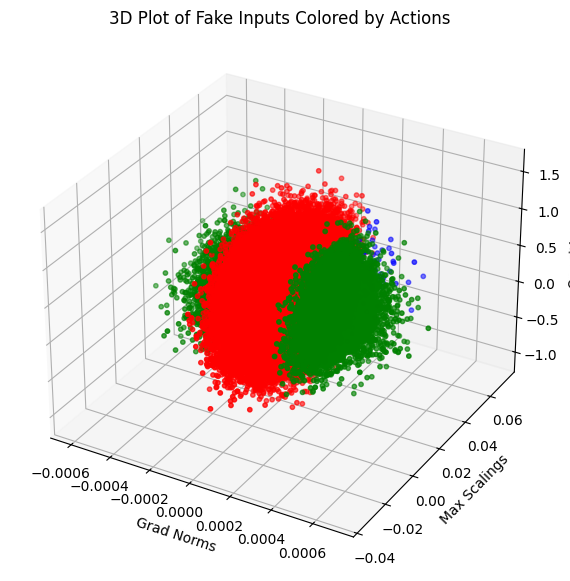

In [36]:
if len(inputs_np) <= 300000:
    # Create a 3D scatter plot of the inputs, colored by action
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Define colors for each action
    if pruning:
        colors = ['red', 'green', 'blue', 'purple']
    else:
        
        colors = ['red', 'green', 'blue']
    # RED = Noop, GREEN = Clone, BLUE = Split
    action_colors = np.array([colors[a] for a in actions_np])

    # Plot the inputs in 3D, colored by action
    sc = ax.scatter(inputs_np[:, 0], inputs_np[:, 1], inputs_np[:, 2], c=action_colors, s=10)

    # Set axis labels
    ax.set_xlabel('Grad Norms')
    ax.set_ylabel('Max Scalings')
    ax.set_zlabel('Opacities')
    ax.set_title('3D Plot of Fake Inputs Colored by Actions')

    # Show the plot
    plt.show()

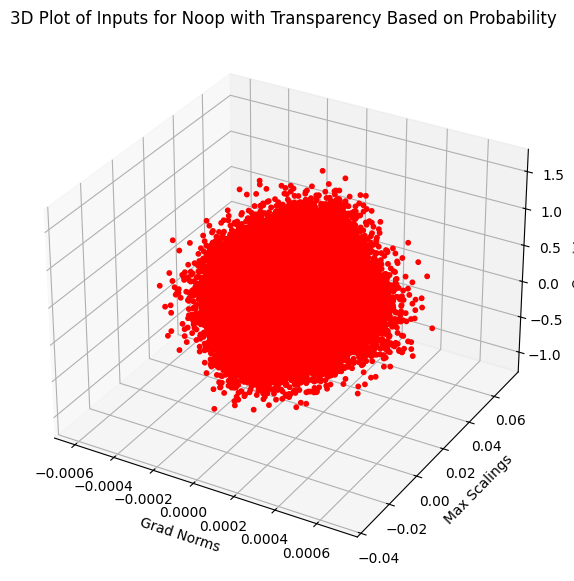

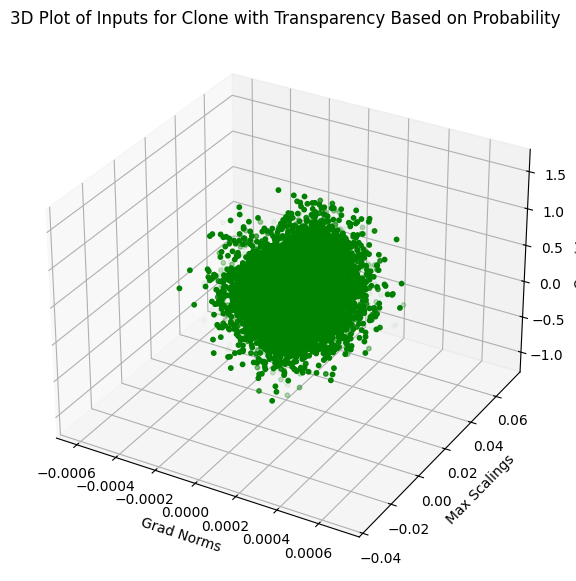

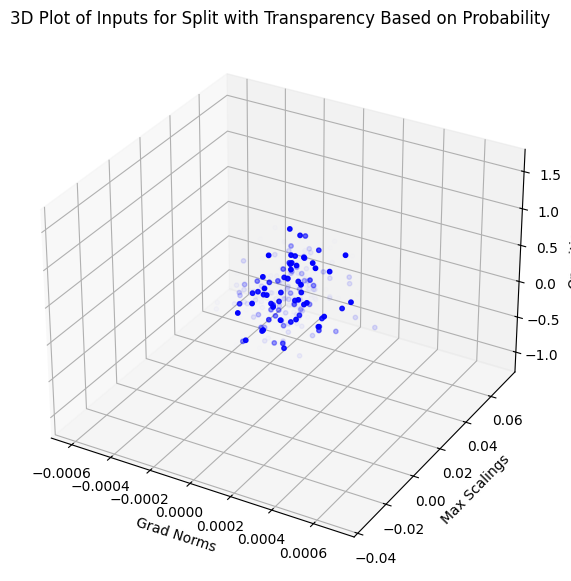

In [37]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming inputs_np is a numpy array of shape [N, 3] containing the input features
# And action_probs is a numpy array of shape [N, 3] containing the probabilities for each action

# Define action names and corresponding colors
actions = ['Noop', 'Clone', 'Split']
colors = ['red', 'green', 'blue']  # Noop = red, Clone = green, Split = blue
if pruning:
    actions.append('Prune')
    colors.append('purple') 

# Now you can proceed to plot each action's 3D scatter plot with transparency based on probabilities
for i, action_name in enumerate(actions):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Set the alpha (transparency) based on the action probability for the current action
    alpha_values = action_probs_np[:, i]  # Use detached action probabilities

    # Plot the inputs with transparency based on the action probability
    sc = ax.scatter(inputs_np[:, 0], inputs_np[:, 1], inputs_np[:, 2], c=colors[i], alpha=alpha_values, s=10)

    # Set axis labels and title
    ax.set_xlabel('Grad Norms')
    ax.set_ylabel('Max Scalings')
    ax.set_zlabel('Opacities')
    ax.set_title(f'3D Plot of Inputs for {action_name} with Transparency Based on Probability')

    # Show the plot
    plt.show()

In [38]:
#import plotly.graph_objects as go
# Create the 3D scatter plot using Plotly
#fig = go.Figure(data=[go.Scatter3d(
#     x=inputs_np[:, 0],
#    y=inputs_np[:, 1],
#    z=inputs_np[:, 2],
#    mode='markers',
#    marker=dict(
#        size=5,
#        color=action_colors,  # Color points by action
#        opacity=0.8
#    )
#)])

# Set plot title and axis labels
#fig.update_layout(
#    title="Interactive 3D Plot of Fake Inputs Colored by Actions",
#    scene=dict(
#        xaxis_title="Grad Norms",
#        yaxis_title="Max Scalings",
#        zaxis_title="Opacities"
#    )
#)

# Show the plot


Statistics for action 'Noop':
Grad Norms: Mean = 2.2765e-05, Std = 7.8266e-05, Median = 2.3525e-05
Max Scalings: Mean = 2.0262e-02, Std = 1.1825e-02, Median = 2.0229e-02
Opacities: Mean = 1.9528e-01, Std = 2.9558e-01, Median = 1.8589e-01

Statistics for action 'Clone':
Grad Norms: Mean = 1.3872e-04, Std = 2.3006e-04, Median = 2.3120e-04
Max Scalings: Mean = 2.0733e-02, Std = 1.0394e-02, Median = 2.0869e-02
Opacities: Mean = 1.7741e-01, Std = 2.8829e-01, Median = 1.6764e-01

Statistics for action 'Split':
Grad Norms: Mean = 2.6329e-04, Std = 6.5898e-05, Median = 2.3971e-04
Max Scalings: Mean = 5.1220e-02, Std = 3.9680e-03, Median = 5.0631e-02
Opacities: Mean = 2.3064e-01, Std = 3.0071e-01, Median = 1.8589e-01


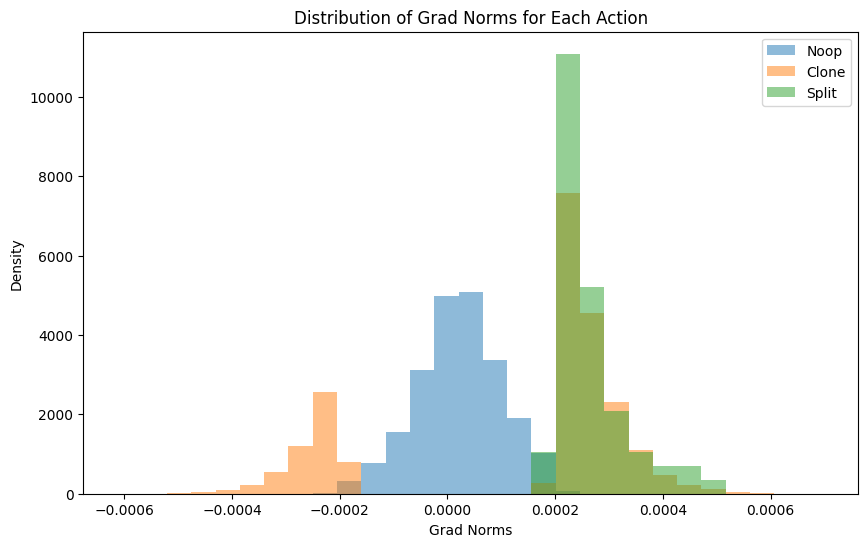

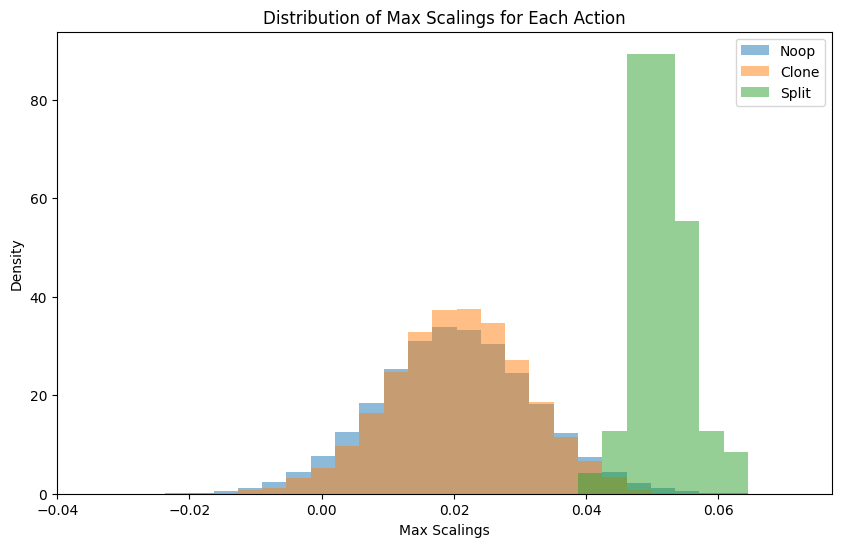

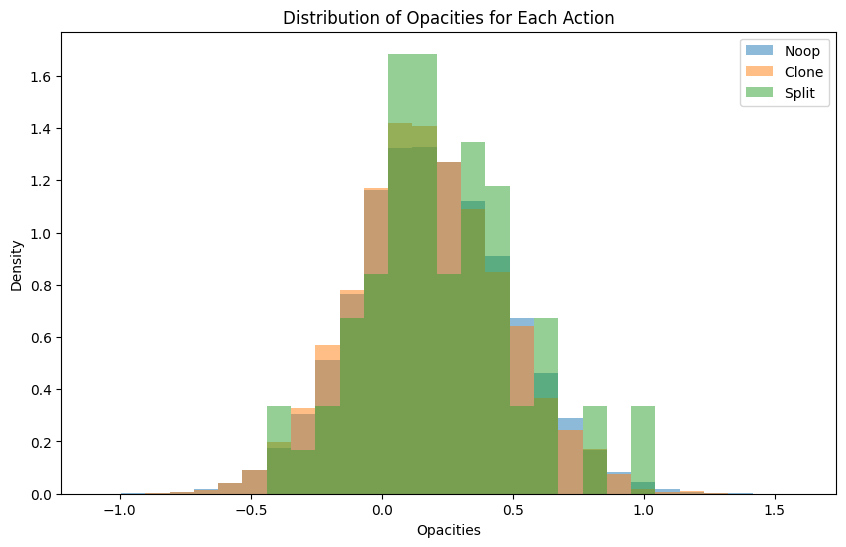

/tmp/ipykernel_18777/2479586004.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=actions)


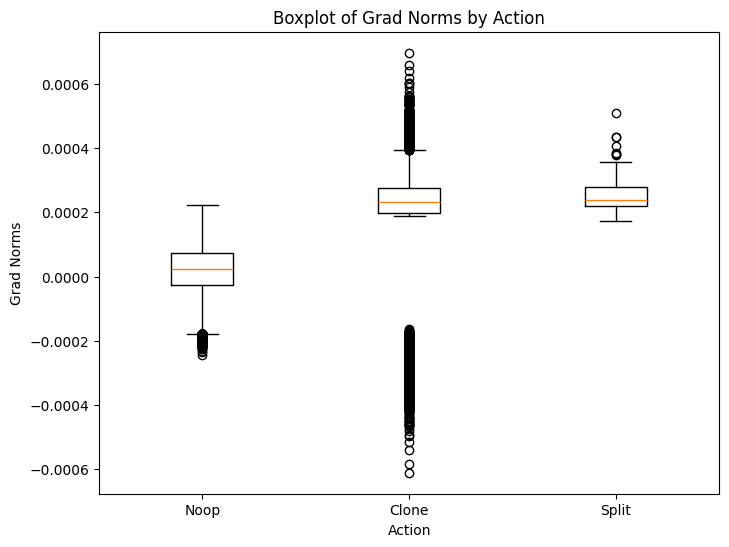

/tmp/ipykernel_18777/2479586004.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=actions)


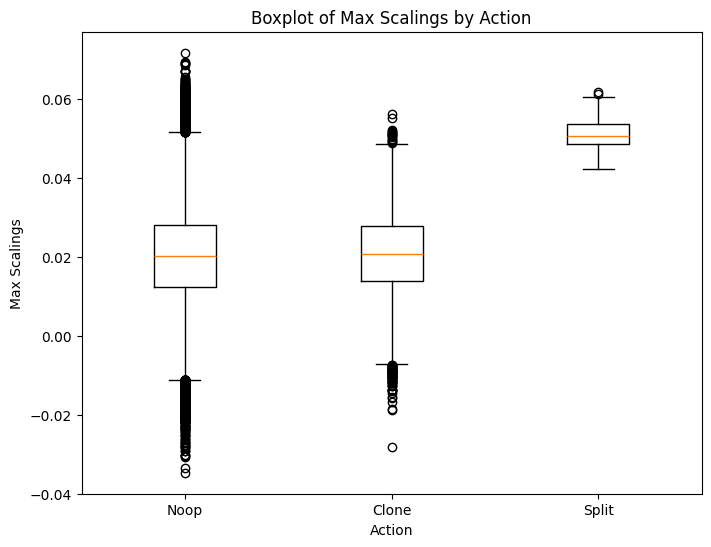

/tmp/ipykernel_18777/2479586004.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=actions)


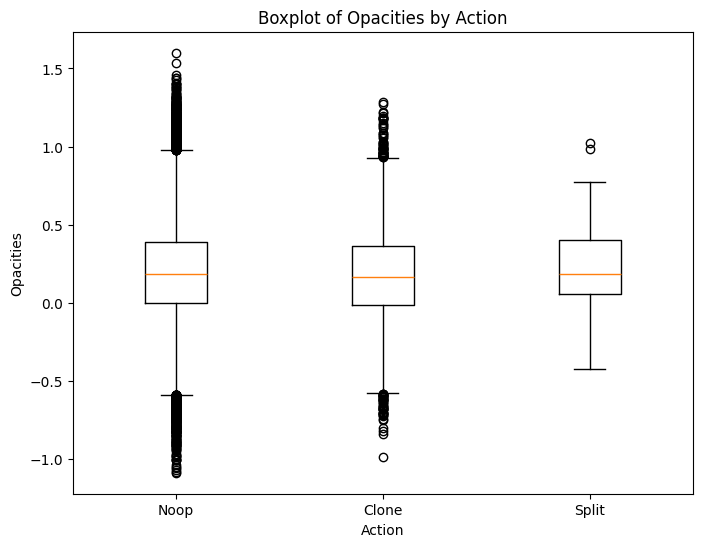

t-test between 'Noop' and 'Clone' for 'Grad Norms': p-value = 0.0000e+00


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Assuming inputs_np is a numpy array of shape [N, 3] containing the input features
# actions_np is a numpy array of shape [N] containing the action indices (0, 1, 2)

# Separate the inputs based on actions
inputs_noop = inputs_np[actions_np == 0]
inputs_clone = inputs_np[actions_np == 1]
inputs_split = inputs_np[actions_np == 2]
if pruning:
    inputs_prune = inputs_np[actions_np == 3]

# Compute statistics for each input feature within each action group
def compute_stats(inputs):
    mean = np.mean(inputs, axis=0)
    std = np.std(inputs, axis=0)
    median = np.median(inputs, axis=0)
    return mean, std, median

mean_noop, std_noop, median_noop = compute_stats(inputs_noop)
mean_clone, std_clone, median_clone = compute_stats(inputs_clone)
mean_split, std_split, median_split = compute_stats(inputs_split)
if pruning:
    mean_prune, std_prune, median_prune = compute_stats(inputs_prune)

# Print out the statistics
feature_names = ['Grad Norms', 'Max Scalings', 'Opacities']
actions = ['Noop', 'Clone', 'Split']
if pruning:
    actions.append('Prune')

for i, action_name in enumerate(actions):
    if i == 0:
        mean, std, median = mean_noop, std_noop, median_noop
    elif i == 1:
        mean, std, median = mean_clone, std_clone, median_clone
    elif i == 2:
        mean, std, median = mean_split, std_split, median_split
    elif pruning and i == 3:
        mean, std, median = mean_prune, std_prune, median_prune
    
    print(f"\nStatistics for action '{action_name}':")
    for j, feature_name in enumerate(feature_names):
        print(f"{feature_name}: Mean = {mean[j]:.4e}, Std = {std[j]:.4e}, Median = {median[j]:.4e}")

# Visualize distributions using histograms
for j, feature_name in enumerate(feature_names):
    plt.figure(figsize=(10, 6))
    bins = np.linspace(np.min(inputs_np[:, j]), np.max(inputs_np[:, j]), 30)
    plt.hist(inputs_noop[:, j], bins=bins, alpha=0.5, label='Noop', density=True)
    plt.hist(inputs_clone[:, j], bins=bins, alpha=0.5, label='Clone', density=True)
    plt.hist(inputs_split[:, j], bins=bins, alpha=0.5, label='Split', density=True)
    if pruning:
        plt.hist(inputs_prune[:, j], bins=bins, alpha=0.5, label='Prune', density=True)
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature_name} for Each Action')
    plt.legend()
    plt.show()

# Alternatively, use boxplots
for j, feature_name in enumerate(feature_names):
    data = [inputs_noop[:, j], inputs_clone[:, j], inputs_split[:, j]]
    if pruning:
        data.append(inputs_prune[:, j])
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, labels=actions)
    plt.xlabel('Action')
    plt.ylabel(feature_name)
    plt.title(f'Boxplot of {feature_name} by Action')
    plt.show()

# Perform statistical tests
# For example, test if the mean of 'Grad Norms' is different between 'Noop' and 'Clone'
stat, p_value = ttest_ind(inputs_noop[:, 0], inputs_clone[:, 0], equal_var=False)
print(f"t-test between 'Noop' and 'Clone' for 'Grad Norms': p-value = {p_value:.4e}")

# You can repeat this test for other pairs and features


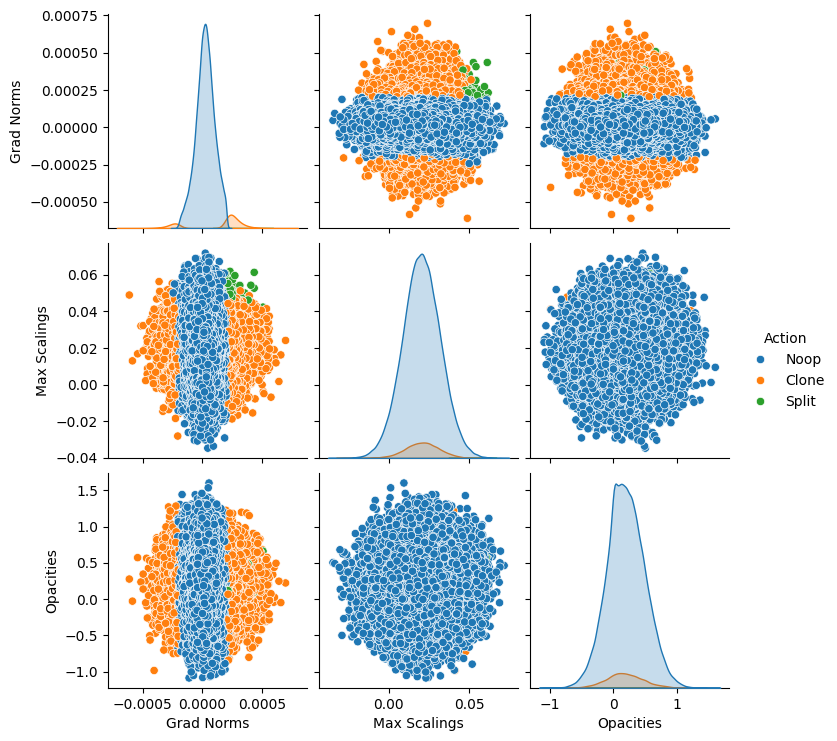

In [40]:
import pandas as pd
import seaborn as sns

# Create a DataFrame
data = np.hstack((inputs_np, actions_np.reshape(-1, 1)))
df = pd.DataFrame(data, columns=['Grad Norms', 'Max Scalings', 'Opacities', 'Action'])
#df['Action'] = df['Action'].map({0: 'Noop', 1: 'Clone', 2: 'Split'})
# Map actions to their respective names
action_mapping = {0: 'Noop', 1: 'Clone', 2: 'Split'}

# If prune is set, add it to the action mapping
if pruning:
    action_mapping[3] = 'Prune'

# Apply the action mapping to the 'Action' column
df['Action'] = df['Action'].map(action_mapping)
# Pair plot
sns.pairplot(df, hue='Action', diag_kind='kde')
plt.show()


In [41]:
from scipy.stats import pearsonr, spearmanr

# For each action probability
for i, action_name in enumerate(actions):
    print(f"\nCorrelation with action probability '{action_name}':")
    for j, feature_name in enumerate(feature_names):
        corr, _ = spearmanr(inputs_np[:, j], action_probs_np[:, i])
        print(f"  {feature_name}: Spearman correlation = {corr:.4f}")



Correlation with action probability 'Noop':
  Grad Norms: Spearman correlation = -0.1247
  Max Scalings: Spearman correlation = -0.0157
  Opacities: Spearman correlation = 0.0223

Correlation with action probability 'Clone':
  Grad Norms: Spearman correlation = -0.1775
  Max Scalings: Spearman correlation = 0.0090
  Opacities: Spearman correlation = -0.0397

Correlation with action probability 'Split':
  Grad Norms: Spearman correlation = 0.5007
  Max Scalings: Spearman correlation = 0.7572
  Opacities: Spearman correlation = 0.0213


In [42]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import train_test_split

# Prepare data
#X = inputs_np  # Input features
#y = actions_np  # Agent's actions

# Split into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the model
#clf = RandomForestClassifier(n_estimators=100)
#clf.fit(X_train, y_train)

# Evaluate the model
#accuracy = clf.score(X_test, y_test)
#print(f"Random Forest accuracy: {accuracy:.4f}")

# Feature importances
#importances = clf.feature_importances_
#for i, feature_name in enumerate(feature_names):
#    print(f"Feature '{feature_name}' importance: {importances[i]:.4f}")



In [43]:
#from scipy.stats import pearsonr, spearmanr

# For each action probability
#for i, action_name in enumerate(actions):
#    print(f"\nCorrelation with action probability '{action_name}':")
#    for j, feature_name in enumerate(feature_names):
#        corr, _ = spearmanr(inputs_np[:, j], action_probs_np[:, i])
#        print(f"  {feature_name}: Spearman correlation = {corr:.4f}")
